In [61]:
import lightning as L
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.utilities.model_summary import ModelSummary

import torch.optim as optim

from tqdm.auto import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy  as np
import tracemalloc 
import glob
import json
import os
import gc
import time
import sys

sys.path.insert(0, os.path.join(os.path.abspath(''), ".."))
from model.builder import LSTMModel, LSTMAttentionModel, CNNLSTMModel, CNNLSTMAttentionModel, CNNAttentionModel, CNNModel, ConvLSTMModel, ConvLSTMAttentionModel
from datamodule.datamodule import DataModule, FFTDataModule

import warnings
warnings.filterwarnings("ignore")

In [27]:

data_module = DataModule(
    test_user=0, 
    missing_sensor_numbers=1,
    batch_size=512,
    test_mode=False)
data_module.setup("fit")
test_loader = data_module.train_dataloader()
            

In [28]:
print(len(test_loader))

80


In [ ]:
import seaborn as sns
fig, axs = plt.subplots(len(test_loader))
for i, batch in enumerate(test_loader):
    no_seq_batch = batch[0][:,:,0]
    sns.heatmap(no_seq_batch, ax=axs[i])

In [51]:
from itertools import combinations

class Test():
    TRAIN_MODE = "train"
    TEST_MODE = "test"
    
    def __init__(self, mode, missing_sensor_numbers=0):
        self.mode = mode
        assert mode in [self.TRAIN_MODE, self.TEST_MODE]
        SENSOR_NUM = 7
        
        self.features = np.random.rand(50, 42, 256)
        self.label = np.random.randint(0, 10, size=(50,))
        assert len(self.features) == len(self.label), "features len is not equal to label len"
        self.missing_sensor_numbers = missing_sensor_numbers

        self.missing_index_list = []
        
        if self.mode == self.TRAIN_MODE:
            for missing_count in range(missing_sensor_numbers + 1):
                for missing_index in combinations(range(SENSOR_NUM), missing_count):
                    self.missing_index_list.append(missing_index)
                    
        elif self.mode == self.TEST_MODE:
                self.missing_index_list = list(combinations(range(SENSOR_NUM), missing_sensor_numbers))
    def __len__(self):

        # take all available missing pattern * data number
        return len(self.features) * len(self.missing_index_list)
        
    def transform(self, one_feature, missing_sensor_id_list):
        # Make one sensor data become 0
        one_feature_cp = one_feature.copy()
        
        for missing_sensor_id in missing_sensor_id_list:
            one_feature_cp[missing_sensor_id*6:(missing_sensor_id+1)*6, :] = 0
        return one_feature_cp

    def __getitem__(self, idx):
        # take all available missing pattern
        missing_sensor_id_list = self.missing_index_list[ idx // len(self.features) ]
        x = self.transform(self.features[ idx % len(self.features) ], missing_sensor_id_list)
        label = self.label[idx % len(self.features)]
        return x, int(label)


In [58]:
test_dataset = Test(mode = "test", missing_sensor_numbers = 2)
print(len(test_dataset))
test_dataset_data = []
for i in range(len(test_dataset)):
    test_dataset_data.append(test_dataset[i][0])
test_dataset_data = np.array(test_dataset_data)
print(test_dataset_data.shape)


1050
(1050, 42, 256)


<Axes: >

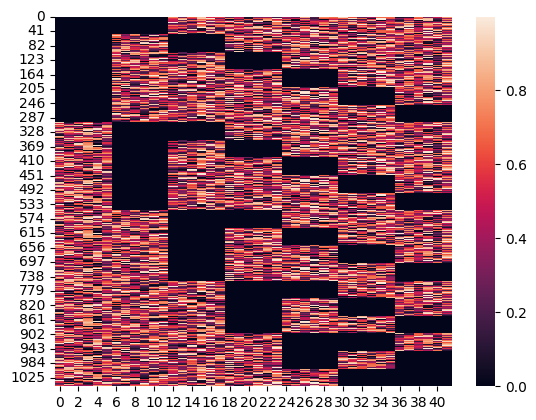

In [59]:
no_seq_batch = test_dataset_data[:,:,0]
sns.heatmap(no_seq_batch)

In [60]:
print(test_dataset.missing_index_list)

[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 3), (2, 4), (2, 5), (2, 6), (3, 4), (3, 5), (3, 6), (4, 5), (4, 6), (5, 6)]


In [70]:
model_class = LSTMModel
model_name = model_class.__name__
result_dict = dict()
for missing_sensor_numbers in range(7):
        
    user = 0
    log_save_dir = os.path.join("../data/compgan_dataset/", "results", "82_classify_CV")
    log_save_name = f"{model_name}/6_missing/user{user}"
    ckpt = glob.glob(os.path.join(log_save_dir, log_save_name, "version_0", "checkpoints", "*.ckpt"))[0]

    data_module = DataModule(
        test_user=user, 
        missing_sensor_numbers=missing_sensor_numbers,
        batch_size=2,
        test_mode=True)

    net = model_class.load_from_checkpoint(ckpt)
                
    trainer = L.Trainer(
        accelerator="gpu", 
        )

    trainer.test(model=net, datamodule=data_module)
    print("logged_metrics", trainer.logged_metrics)
    result_dict[missing_sensor_numbers] = trainer.logged_metrics
print(result_dict)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.84112149477005
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
teardown
logged_metrics {'test_acc': tensor(0.8411)}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7997329831123352
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
teardown
logged_metrics {'test_acc': tensor(0.7997)}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.726969301700592
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
teardown
logged_metrics {'test_acc': tensor(0.7270)}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.6359145641326904
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
teardown
logged_metrics {'test_acc': tensor(0.6359)}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5371161699295044
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
teardown
logged_metrics {'test_acc': tensor(0.5371)}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.46417444944381714
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
teardown
logged_metrics {'test_acc': tensor(0.4642)}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5320427417755127
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
teardown
logged_metrics {'test_acc': tensor(0.5320)}
{0: {'test_acc': tensor(0.8411)}, 1: {'test_acc': tensor(0.7997)}, 2: {'test_acc': tensor(0.7270)}, 3: {'test_acc': tensor(0.6359)}, 4: {'test_acc': tensor(0.5371)}, 5: {'test_acc': tensor(0.4642)}, 6: {'test_acc': tensor(0.5320)}}


In [71]:
result_dict

{0: {'test_acc': tensor(0.8411)},
 1: {'test_acc': tensor(0.7997)},
 2: {'test_acc': tensor(0.7270)},
 3: {'test_acc': tensor(0.6359)},
 4: {'test_acc': tensor(0.5371)},
 5: {'test_acc': tensor(0.4642)},
 6: {'test_acc': tensor(0.5320)}}